In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sm = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [6]:
obj = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [7]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

3451 genes across 2730 cells


In [8]:
dict_annotation = {}

dict_annotation['1Ery']='Ery'
dict_annotation['2Ery']='Ery'
dict_annotation['3Ery']='Ery'
dict_annotation['4Ery']='Ery'
dict_annotation['5Ery']='Ery'
dict_annotation['6Ery']='Ery'
dict_annotation['7MEP']='MEP'
dict_annotation['8Mk']='Mk'
dict_annotation['9GMP']='GMP'
dict_annotation['10GMP']='GMP'
dict_annotation['11DC']='DC'
dict_annotation['12Baso']='Baso'
dict_annotation['13Baso']='Baso'
dict_annotation['14Mo']='Mo'
dict_annotation['15Mo']='Mo'
dict_annotation['16Neu']='Neu'
dict_annotation['17Neu']='Neu'
dict_annotation['18Eos']='Eos'
dict_annotation['19Lymph']='Lymph'

annotation = []
for celltype in obj.obs["paul15_clusters"].tolist():
    annotation.append(dict_annotation[celltype])

obj.obs['annotation'] = annotation
obj.obs['annotation'] = obj.obs['annotation'].astype("category")

#### Data preparation

In [9]:
sm.data_preparation(obj)

#### Removing general genes

In [10]:
s1 = time.time()

In [11]:
obj = sm.remove_general_genes(obj)

#### Removing house-keeping genes

http://www.housekeeping.unicamp.br/?homePageGlobal

In [12]:
obj = sm.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_Mouse_bone_marrow.txt")
obj = sm.remove_housekeepingenes(obj, path="../../data/house_keeping_genes_Mouse_HSC.txt")

#### Removing genes expressed in less than 30% within groups

In [13]:
obj = sm.remove_features_pct(obj, group_by="annotation", pct=0.3)

#### Removing genes expressed in more than 50% in a given group where genes are expressed for more 75% within a given group

In [14]:
obj = sm.remove_features_pct_2groups(obj, group_by="annotation", pct1=0.75, pct2=0.5)

#### Revert PCA

In [15]:
obj = sm.scale_filter_features(obj, n_components=None, filter_expression=True)

Fraction passing PCA: 0.98786717752235


#### ensemble_learning

In [16]:
s2 = time.time()

Running with Balanced Random Forest


<Figure size 432x288 with 0 Axes>

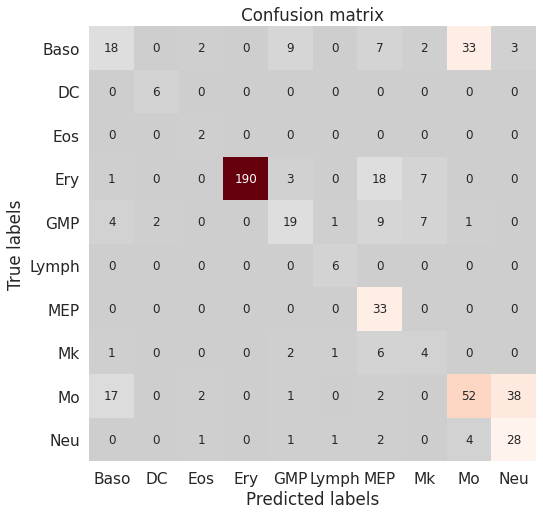

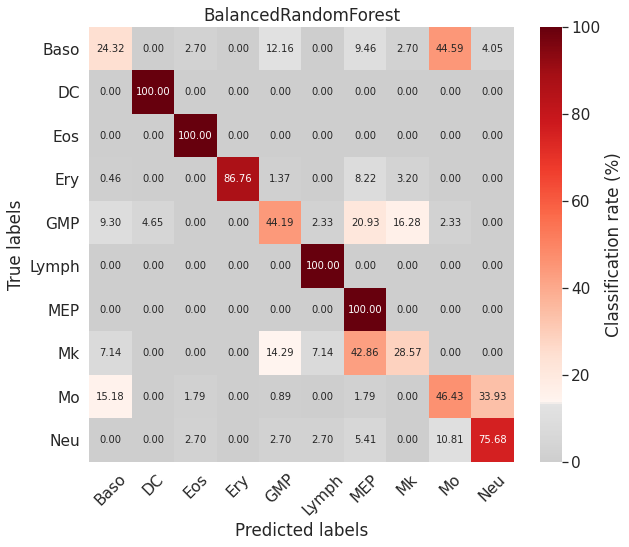

Accuracy: 0.6556776556776557: Misclassification: 0.3443223443223443
              precision    recall  f1-score   support

        Baso       0.44      0.24      0.31        74
          DC       0.75      1.00      0.86         6
         Eos       0.29      1.00      0.44         2
         Ery       1.00      0.87      0.93       219
         GMP       0.54      0.44      0.49        43
       Lymph       0.67      1.00      0.80         6
         MEP       0.43      1.00      0.60        33
          Mk       0.20      0.29      0.24        14
          Mo       0.58      0.46      0.51       112
         Neu       0.41      0.76      0.53        37

    accuracy                           0.66       546
   macro avg       0.53      0.71      0.57       546
weighted avg       0.70      0.66      0.66       546



In [17]:
clf = sm.ensemble_learning(obj, group_by="annotation", classifier="BalancedRandomForest", balance=True, verbose=True, save=False)

#### gini_importance

In [18]:
selectedGenes, selectedGenes_dict = sm.gini_importance(obj, clf, group_by="annotation", verbose=True, restrict_top=("local", 20))

In [19]:
e2 = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

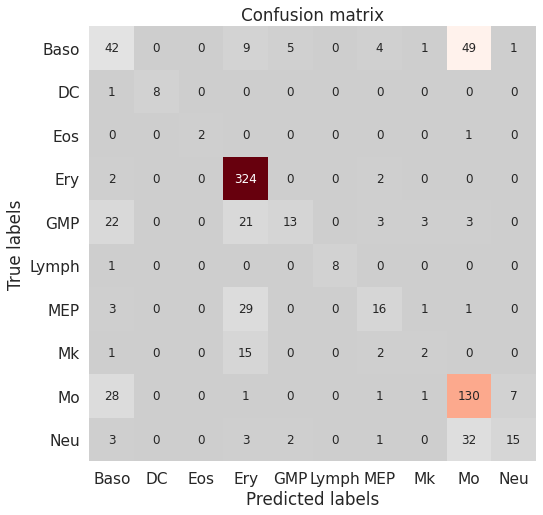

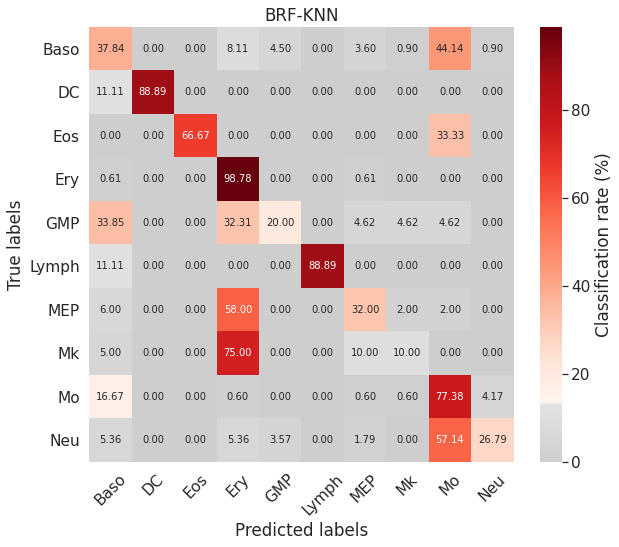

Accuracy: 0.6837606837606838: Misclassification: 0.3162393162393162
              precision    recall  f1-score   support

        Baso       0.41      0.38      0.39       111
          DC       1.00      0.89      0.94         9
         Eos       1.00      0.67      0.80         3
         Ery       0.81      0.99      0.89       328
         GMP       0.65      0.20      0.31        65
       Lymph       1.00      0.89      0.94         9
         MEP       0.55      0.32      0.41        50
          Mk       0.25      0.10      0.14        20
          Mo       0.60      0.77      0.68       168
         Neu       0.65      0.27      0.38        56

    accuracy                           0.68       819
   macro avg       0.69      0.55      0.59       819
weighted avg       0.66      0.68      0.65       819



In [20]:
sm.run_classifiers(obj, group_by="annotation", genes=selectedGenes, classifier="KNN", balance=True, title="BRF-KNN", save=False)

#### Sorting genes per cluster

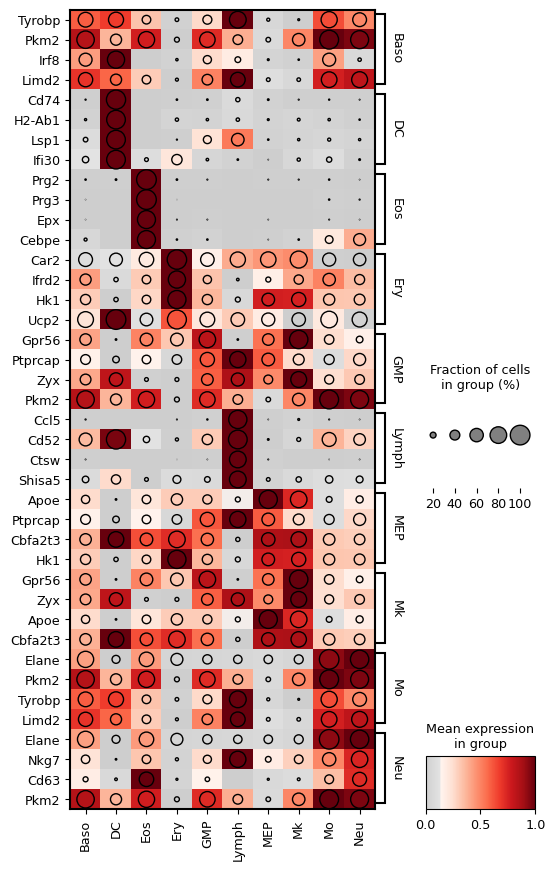

In [21]:
axs, selectedGenes_top_dict = sm.sort_and_plot(obj, selectedGenes, group_by="annotation", top=4, figsize=(6,10))

In [22]:
e1 = time.time()

In [23]:
# axs.savefig("Figures/BRF_top5_perGroup.pdf")

# Elapsed time

In [24]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

1547 genes across 2730 cells


In [25]:
print('Elapsed time (s): ', e1-s1)

Elapsed time (s):  39.76836562156677


In [26]:
print('Elapsed time (s): ', e2-s2)

Elapsed time (s):  1.9442288875579834
